In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path="/content/drive/MyDrive/Colab Notebooks/mydataset"
train_path='/content/drive/MyDrive/Colab Notebooks/mydataset/train'
test_path='/content/drive/MyDrive/Colab Notebooks/mydataset/test'

In [ ]:
IMAGE_SIZE = 200
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                 image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 shuffle=True
                                                 )

Found 5232 files belonging to 3 classes.


In [ ]:
for image_batch, label_batch in dataset.take(1):
   print(image_batch[0].shape)

(200, 200, 3)


In [ ]:
class_names= dataset.class_names
class_names

['BACTERIAL PNEUMONIA', 'NORMAL', 'VIRAL PNEUMONIA']

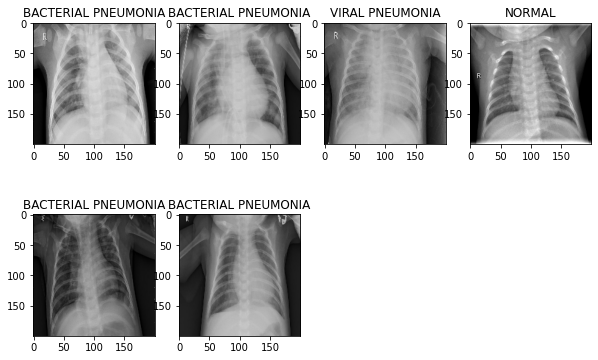

In [ ]:
 plt.figure(figsize=(10,10))
 for image_batch, label_batch in dataset.take(1):
   for i in range(6):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]])

In [ ]:
train_size = 0.8
len(dataset)*train_size

131.20000000000002

In [ ]:
train_ds = dataset.take(131)
len(train_ds)

131

In [ ]:
test_ds = dataset.skip(131)
len(test_ds)

33

In [ ]:
val_size=0.1
len(dataset)*val_size

16.400000000000002

In [ ]:
val_ds = test_ds.take(16)
len(val_ds)

16

In [ ]:
test_ds = test_ds.skip(16)
len(test_ds)

17

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
                                          layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
                                          layers.experimental.preprocessing.Rescaling(1.0/255)

])


In [ ]:
data_augmentation= tf.keras.Sequential([
                                        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                                        layers.experimental.preprocessing.RandomRotation(10),
                                        tf.keras.layers.RandomZoom(0.2),

                                        ])

In [ ]:
vgg = VGG19(input_shape=(200, 200, 3), weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

In [ ]:
prediction = Dense(len(class_names), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS)

Epoch 1/10
131/131 [==============================] - 1564s 437ms/step - loss: 4.4883 - accuracy: 0.7359 - val_loss: 2.8506 - val_accuracy: 0.8066
Epoch 2/10
131/131 [==============================] - 24s 181ms/step - loss: 2.2919 - accuracy: 0.8372 - val_loss: 2.0832 - val_accuracy: 0.8555
Epoch 3/10
131/131 [==============================] - 24s 181ms/step - loss: 1.6661 - accuracy: 0.8843 - val_loss: 2.2567 - val_accuracy: 0.8438
Epoch 4/10
131/131 [==============================] - 24s 181ms/step - loss: 1.7762 - accuracy: 0.8831 - val_loss: 1.6135 - val_accuracy: 0.8926
Epoch 5/10
131/131 [==============================] - 23s 178ms/step - loss: 0.5844 - accuracy: 0.9373 - val_loss: 1.2759 - val_accuracy: 0.9160
Epoch 6/10
131/131 [==============================] - 23s 178ms/step - loss: 0.5176 - accuracy: 0.9461 - val_loss: 1.4750 - val_accuracy: 0.9121
Epoch 7/10
131/131 [==============================] - 24s 180ms/step - loss: 0.5982 - accuracy: 0.9461 - val_loss: 2.3861 - val_

In [ ]:
scores= model.evaluate(test_ds)

17/17 [==============================] - 3s 163ms/step - loss: 1.5745 - accuracy: 0.9191


In [ ]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

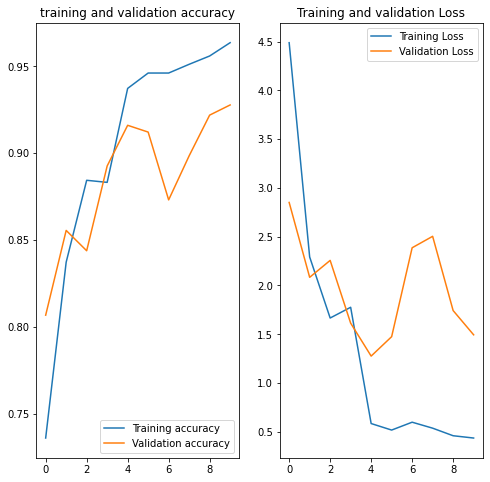

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title("training and validation accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc='upper right')
plt.show()

first image to predict
actual label: BACTERIAL PNEUMONIA
predicted label: BACTERIAL PNEUMONIA


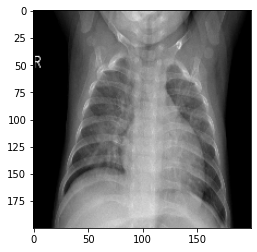

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
new = [np.argmax(batch_prediction[i])for i in labels_batch]


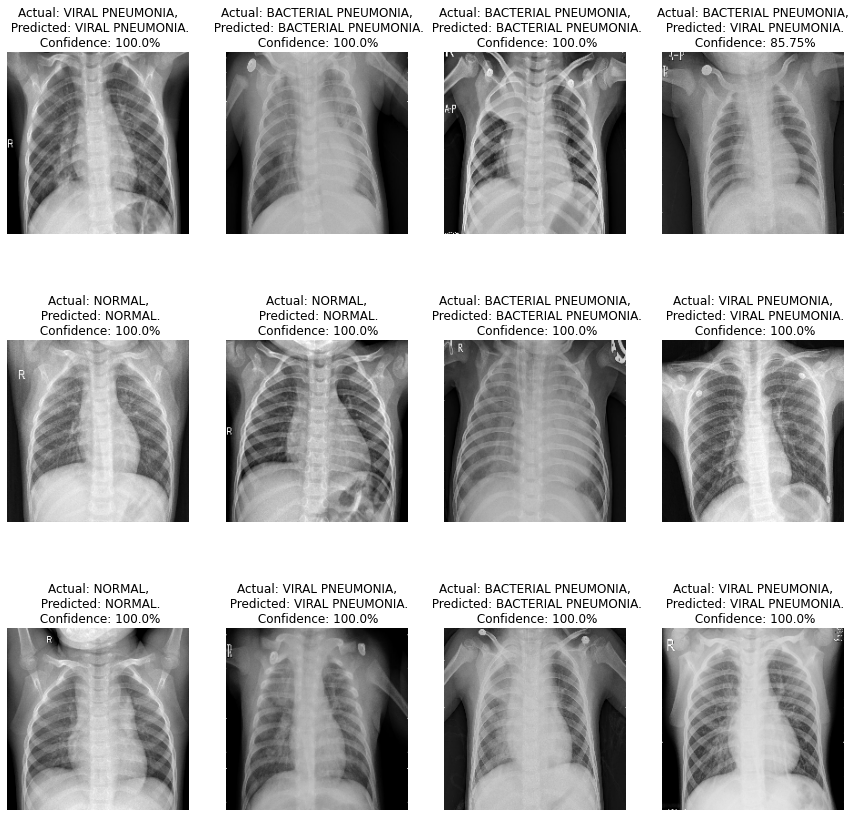

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
cmlabel= [labels_batch[i].numpy() for i in labels_batch]





In [ ]:

cm = tf.math.confusion_matrix(labels=cmlabel , predictions=new)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[17,  0,  0],
       [ 0,  6,  0],
       [ 9,  0,  0]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

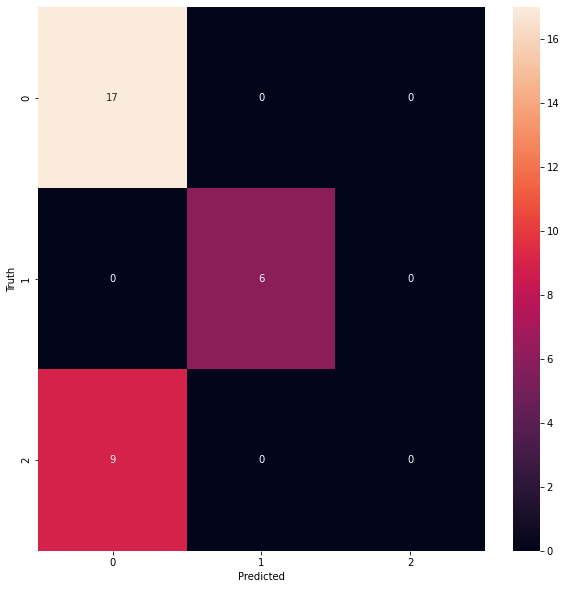

In [ ]:
import seaborn as sn
plt.figure(figsize = (10,10))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')